In [3]:
import numpy as np
from dataframe import Data
from SNANA_FITS_to_pd import read_fits
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
from io_utils import *
from random import random
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [4]:
dataset_val = 0

In [6]:
if dataset_val == 0:
    dataset =  "PLAsTiCC"
    data_ob = load_PLAsTiCC_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids=data_ob.get_ids_of_event_type(64)
    color_band_dict = {0:'C4',1:'C2', 2:'C3', 3:'C1', 4:'k', 5:'C5'}

In [7]:
if dataset_val == 1:    
    dataset = "ZTF"
    data_ob = load_ztf_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids = object_ids
    color_band_dict = {b'g ':'C2', b'r ':'C3'}

In [8]:
from LightCurve import LightCurve

In [9]:
def get_band_max_point(band_df):
    loc = np.argmax(band_df[data_ob.flux_col_name])
    date = band_df[data_ob.time_col_name][loc]
    max_flux = band_df[data_ob.flux_col_name][loc]
    return date, max_flux

In [10]:
def get_PCs(num_components, all_bands= False):
    
    if all_bands == True:
        PC_dict = np.load("principal_components/PC_all_bands_diff_mid_pt_dict.npy")
        PC_dict = PC_dict.item()
        PC_out = {}
        #num_components = int(num_components)
        #print(PC_dict['u'])
        PC_out[0] = PC_dict['u'][0:3]
        PC_out[1] = PC_dict['r'][0:3]
        PC_out[2] = PC_dict['i'][0:3]
        PC_out[3] = PC_dict['g'][0:3]
        PC_out[4] = PC_dict['z'][0:3]
        PC_out[5] = PC_dict['Y'][0:3]
        
    else:
        PC_out={}
        PCs = np.load("principal_components/PCs.npy")
        for band in data_ob.band_map.keys():
            PC_out[band] = PCs[0:num_components]
            
    return PC_out

In [11]:
def optimize_coeff(band_df, mid_point_date, current_date, PCs, no_of_predicted_days=51, time_step = 2):
    
    if(len(band_df)>0): 

        start_date=mid_point_date-(no_of_predicted_days-1)*time_step/2 
        end_date= mid_point_date+(no_of_predicted_days-1)*time_step/2 
        start_index = band_df[data_ob.time_col_name] >= start_date
        end_index = band_df[data_ob.time_col_name] <= end_date 
        
        past_index = band_df[data_ob.time_col_name] <= current_date 
        fit_df = band_df[start_index&end_index&past_index]
        
        if len(fit_df)>0:
            
            binned_dates = get_binned_time(fit_df)
            b2 = (binned_dates-mid_point_date+no_of_predicted_days-1)/2
            b2 = b2.astype(int)
            light_curve_seg = np.zeros((no_of_predicted_days))
            light_curve_seg[b2[:]] = fit_df[data_ob.flux_col_name]
            #initial_guess = np.amax(fit_df[data_ob.flux_col_name])*np.array([.93,.03 ,.025])
            initial_guess = [.93,.03 ,.025]
            result = minimize(calc_loss, initial_guess, args=(PCs, light_curve_seg))
            
            return result.x
        
        
            predicted_lt_curve = calc_prediction(result.x,PCs)
            x_data = np.arange(start_date,end_date+2,2)
            
            return x_data, predicted_lt_curve, result.x
        
    return []
            

In [12]:
def calc_prediction(coeff, PCs):
    predict_comb = np.zeros_like(PCs.shape[1])
    for a,b in zip(PCs,coeff): predict_comb=np.add(predict_comb,b*a)
    return predict_comb

In [13]:
def calc_loss(coeff, PCs, light_curve_seg):
    index = light_curve_seg!=0
    y_pred = calc_prediction(coeff,PCs)
    diff = light_curve_seg - y_pred
    neg_index = y_pred<0
    diff = diff[(index)|(neg_index)]
    
    #diff = diff[index]
    
    #error = np.sum(np.square(diff,diff))  np.sum(np.square(regularization_vals-coeff/np.sum(coeff)))*1000
    error = np.sum(np.square(diff,diff))
    return error

In [14]:
def add_to_coeff_arr(coeff_arr, coeff_dict):
    all_coeff = np.array([])
    for key, value in coeff_dict.items():
        if all_coeff.size==0:
            all_coeff = np.asarray(value)
        else:
            all_coeff= np.concatenate((all_coeff, value), axis = 0)
    #print(all_coeff)
        
    if all_coeff.size!=0:
        coeff_arr.append(all_coeff)
        event_type.append(data_ob.get_object_type_number(object_id))
    return coeff_arr

In [15]:
print(len(object_ids))

def get_binned_time(df):
    return df[data_ob.time_col_name]-df[data_ob.time_col_name]%2

7848


In [16]:
from scipy.optimize import minimize

In [17]:
def get_time_segment(event_df, start_date, end_date, current_date=None):

    start_index = event_df[data_ob.time_col_name] >= start_date
    end_index = event_df[data_ob.time_col_name] <= end_date 
    if current_date is None:
        return event_df[start_index&end_index]
    else:
        past_index = event_df[data_ob.time_col_name] <= current_date 
        return event_df[start_index&end_index&past_index]

In [18]:
def predict_lc_coeff(event_df, PC_dict, current_date= None, no_of_predicted_days = 51, time_step=2, bands=None, separate_band_mid= True, min_flux_threshold=30):
    coeff_all_band = {}
    
    if bands is None:
        bands = data_ob.band_map.keys()
        
    #print(bands)
    mid_point_dict = get_mid_pt(event_df, bands, current_date, color_band_dict, separate_band_mid, min_flux_threshold=min_flux_threshold)
    #print(mid_point_dict)
    
    #print(bands)
    #print(mid_point_date)
    if mid_point_dict is not None:
        
        for band in bands:
            mid_point_date = mid_point_dict[band]
            if mid_point_date is None:
                coeff_all_band[band] = [0, 0, 0]
                continue
                
            prediction_start_date=mid_point_date-(no_of_predicted_days-1)*time_step/2 
            prediction_end_date= mid_point_date+(no_of_predicted_days-1)*time_step/2 

            event_df = get_time_segment(event_df, prediction_start_date, prediction_end_date, current_date)
        
            band_index = event_df[data_ob.band_col_name] == band
            band_df = event_df[band_index]
            #print(band_df)
            PCs = PC_dict[band]
            if len(band_df)>0:
                
                binned_dates = get_binned_time(band_df)
                b2 = (binned_dates-mid_point_date+no_of_predicted_days-1)/2
                b2 = b2.astype(int)
                light_curve_seg = np.zeros((no_of_predicted_days))
                light_curve_seg[b2[:]] = band_df[data_ob.flux_col_name]
                initial_guess = np.amax(band_df[data_ob.flux_col_name])*np.array([.93,.03 ,.025])
                result = minimize(calc_loss, initial_guess, args=(PCs, light_curve_seg))
                coeff_all_band[band] = list(result.x)
                
            else:
                coeff_all_band[band] = [0, 0, 0]
                
    else:
        for band in bands:
            coeff_all_band[band] = [0, 0, 0]
                
    return coeff_all_band
            
    
    

In [19]:
import time

In [20]:
print(len(object_ids))

7848


In [21]:
def get_mid_pt(event_df, bands, current_date=None, color_band_dict=None, separate_band_mid = True, min_flux_threshold =30):
    
    mid_point_dict = {}
    
    if current_date is not None:
        date_difference = event_df[data_ob.time_col_name] - current_date
        past_index = (date_difference>=-50) & (date_difference<=0)
        event_df = event_df[past_index]
        #print(event_df)
        if not separate_band_mid:
            band_mid_points = []
            for i,band in enumerate(bands):
                #print(band)
                band_index = event_df[data_ob.band_col_name] == band
                band_df = event_df[band_index]
                #print(band_df)
                if(len(band_df)>0):
                    max_index = np.argmax(band_df[data_ob.flux_col_name])
                    band_mid_points.append(band_df[data_ob.time_col_name][max_index])
            if len(band_mid_points)>0:
                for band in bands:
                    mid_point_dict[band] = np.median(np.array(band_mid_points))
            else:
                return None
        else:
            for band in bands:
                #print(band)
                band_index = event_df[data_ob.band_col_name] == band
                band_df = event_df[band_index]
                #print(band_df)
                if(len(band_df)>0):
                    max_index = np.argmax(band_df[data_ob.flux_col_name])
                    if band_df[data_ob.flux_col_name][max_index]>min_flux_threshold:
                        mid_point_dict[band] = band_df[data_ob.time_col_name][max_index]
                    else:
                        mid_point_dict[band] = None
                else:
                    mid_point_dict[band] = None
         
        
    else:
        lc = LightCurve(event_df, time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
        priority_regions = lc.find_region_priority()
        priority_region1 = priority_regions[0]
        median = np.median(np.asarray(priority_region1))
        event_df = get_time_segment(event_df, median-50, median+50)

        if separate_band_mid:
            
            for band in bands:
                #print(band)
                band_df = lc.extract_band_data(band,event_df)
                #print(band_df)
                if(len(band_df)>0):
                    max_index = np.argmax(band_df[data_ob.flux_col_name])
                    #print(min_flux_threshold)
                    if band_df[data_ob.flux_col_name][max_index]>min_flux_threshold:
                        mid_point_dict[band] = band_df[data_ob.time_col_name][max_index]
                    else: mid_point_dict[band] = None
                else: mid_point_dict[band] = None
        else:
            for band in bands:
                band_df = lc.extract_band_data(band,event_df)
                if len(band_df)>0:
                    #print(min_flux_threshold)
                    if np.amax(band_df[data_ob.flux_col_name]>min_flux_threshold):
                        mid_point_dict[band] = median
                    else: mid_point_dict[band] = None
                else: mid_point_dict[band] = None
    
    #print(mid_point_dict)
    
    return mid_point_dict

In [22]:
def plot_predicted_bands(all_band_coeff_dict, PC_dict, current_date=None, bands=None, mark_maximum = False, x_lims=None, separate_band_mid=True, min_flux_threshold =30):
    if bands is None: 
        bands = data_ob.band_map.keys()
    mid_point_dict = get_mid_pt(event_df, bands, current_date, color_band_dict, separate_band_mid, min_flux_threshold=min_flux_threshold)
    #print(separate_band_mid)
    lc = LightCurve(event_df, time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    fig = lc.plot_light_curve(color_band_dict=color_band_dict, alpha=0.3, mark_maximum = False, mark_label= False, plot_points = True)
    
            
                    
    if mid_point_dict is not None:
        for band, coeff in all_band_coeff_dict.items():
            mid_point_date = mid_point_dict[band]
            #print(mid_point_date)
            if mid_point_date is not None:
                
                if current_date is None:
                    end_date = mid_point_date +50
                else: 
                    end_date = current_date
                    
                if mark_maximum:
                    fig = lc.plot_light_curve(color_band_dict, fig = fig, start_date= mid_point_date -50, end_date=end_date, band = band, alpha=1, mark_maximum = True, plot_points = True)
                else:
                    fig = lc.plot_light_curve(color_band_dict, fig = fig, start_date= mid_point_date -50, end_date=end_date, band = band, alpha=1, mark_maximum = False, plot_points = True)   

                if len(coeff)!=0:
                    predicted_lc= calc_prediction(coeff,PC_dict[band])
                    #plt.plot(x_data, predicted_lc, color = color_band_dict[band])
                    time_data= np.arange(0,102,2) + mid_point_date - 50
                else: 
                    predicted_lc=[]
                    time_data=[]

                plt.plot(time_data, predicted_lc, color = color_band_dict[band])

        if x_lims is not None: 
            plt.xlim(x_lims)
        
        if not separate_band_mid:
            _, _, ymin, ymax = plt.axis()    
            plt.plot([mid_point_date,mid_point_date],[ymin/2,ymax/2],color = "slateblue", ls="dashed", label="median of max dates")
    
    xmin, xmax, ymin, ymax = plt.axis() 
    plt.plot([xmin,xmax],[min_flux_threshold,min_flux_threshold],color= "red", ls="dashed", label="min flux threshold ="+str(min_flux_threshold))
    if current_date is not None:
        plt.plot([current_date,current_date],[ymin/2,ymax/2],color= "darkorange", ls="dashed", label="current date")
        
    ax=plt.gca()
    plt.text(.01,.94,data_ob.object_id_col_name+": "+str(object_id),fontsize=15, transform=ax.transAxes)
    if dataset_val == 0:
        #print(data_ob.get_object_type_for_PLAsTiCC(object_id))
        plt.text(.01,.88,"Type: "+data_ob.get_object_type_for_PLAsTiCC(object_id),fontsize=15, transform=ax.transAxes)
    
    plt.xlabel("mjd", fontsize=20)
    plt.ylabel("flux", fontsize=20)
    
    plt.legend(loc="upper right")
    

# plots assuming we have all data

In [ ]:
PC_dict = get_PCs(3,all_bands=True)
start = time.time()
coeff_arr = []
event_type = []
#object_ids = data_ob.get_ids_of_event_type(6)
fig = plt.figure()
#ax = fig.gca(projection='3d')
coeff_dict_list = []
separate_band_mid = False
mark_maximum = False
min_flux_threshold = 20
for object_id in kilonova_ids:
    event_df = data_ob.get_data_of_event(object_id)
    mid_point_dict = get_mid_pt(event_df, data_ob.band_map.keys(), separate_band_mid=separate_band_mid, min_flux_threshold=min_flux_threshold)
    values = list(mid_point_dict.values())
    lc = LightCurve(event_df, time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    priority_regions = lc.find_region_priority()
    priority_region1 = priority_regions[0]
    mid_point_date = np.median(np.asarray(priority_region1))
    #print(mid_point_date)
    
    #print(current_date)
    coeff_dict = predict_lc_coeff(event_df, PC_dict,separate_band_mid=separate_band_mid, min_flux_threshold= min_flux_threshold)
    #print(coeff_dict)
    coeff_dict_list.append(coeff_dict)
    fig = plot_predicted_bands(coeff_dict, PC_dict, mark_maximum=mark_maximum, x_lims =[mid_point_date-80, mid_point_date+80], separate_band_mid= separate_band_mid, min_flux_threshold=min_flux_threshold)
    
    #coeff_dict = predict_alert_light_curves(current_date,event_df, PC_dict)
    #print(data_ob.get_object_type(object_id))
    #plt.savefig("kilonova_curves/fit_separated_band_lc_with_PCs/target_"+str(data_ob.get_object_type_number(object_id))+"/object_"+str(object_id)+"mid_pt_as_median_PCs_decoupled")
    plt.show()
    plt.close('all')

# Random current date

In [ ]:
PC_dict = get_PCs(3,all_bands=False)
start = time.time()
coeff_arr = []
event_type = []
#object_ids = data_ob.get_ids_of_event_type(6)
#fig = plt.figure()
#ax = fig.gca(projection='3d')
coeff_dict_list = []
object_list= []
separate_band_mid = True
mark_maximum = True
min_flux_threshold = 20
for object_id in object_ids:
    event_df = data_ob.get_data_of_event(object_id)
    mid_point_dict = get_mid_pt(event_df, data_ob.band_map.keys(), separate_band_mid=separate_band_mid, min_flux_threshold=min_flux_threshold)
    values = list(mid_point_dict.values())
    lc = LightCurve(event_df, time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    priority_regions = lc.find_region_priority()
    priority_region1 = priority_regions[0]
    mid_point_date = np.median(np.asarray(priority_region1))
    current_date = mid_point_date+ random()*50-25

    coeff_dict = predict_lc_coeff(event_df, PC_dict, current_date=current_date, separate_band_mid=separate_band_mid, min_flux_threshold=min_flux_threshold)
    coeff_dict_list.append(coeff_dict)
    object_list.append(object_id)
    #fig = plot_predicted_bands(coeff_dict, PC_dict, current_date=current_date, mark_maximum=True, x_lims =[mid_point_date-100, mid_point_date+100], separate_band_mid=separate_band_mid, min_flux_threshold=min_flux_threshold)
    #ax=plt.gca()
    #plt.text(.01,.94,data_ob.object_id_col_name+": "+str(object_id),fontsize=15, transform=ax.transAxes)
    #if dataset_val == 0:
        #print(data_ob.get_object_type_for_PLAsTiCC(object_id))
    #    plt.text(.01,.88,"Type: "+data_ob.get_object_type_for_PLAsTiCC(object_id),fontsize=15, transform=ax.transAxes)
    #plt.legend(loc="upper right")
    
    #coeff_dict = predict_alert_light_curves(current_date,event_df, PC_dict)
    #print(data_ob.get_object_type(object_id))
    #plt.savefig("kilonova_curves/fit_separated_band_lc_with_PCs/target_"+str(data_ob.get_object_type_number(object_id))+"/object_"+str(object_id)+"mid_pt_with_random_current")
    #plt.savefig("kilonova_curves/fit_lc_with_PCs/target_"+str(data_ob.get_object_type_number(object_id))+"/object_"+str(object_id)+"highest_priority_random_curr_date")
    #plt.show()
    #plt.close('all')

#end = time.time()
#print(end - start)

In [ ]:
np.save("coeff_arrays/coeff_dict",coeff_dict_list)

In [23]:
coeff_dict_list = np.load("coeff_arrays/coeff_dict.npy")

In [29]:
print(coeff_dict_list[30])

{0: [0, 0, 0], 1: [304.38555816048716, 138.50758692838866, -82.36907661236002], 2: [904.2369125872499, 376.58905134647296, -98.15849635657888], 3: [1179.6492964269632, 154.35078963195326, -1144.7115536404926], 4: [1753.7519726198286, 181.4990252067102, -1611.1571359065465], 5: [2196.688260949806, 190.61549949823274, -1949.9538557026092]}


In [30]:
def get_kilonova_loc(object_list):
    kn_index=np.zeros(len(object_list), dtype = bool)
    for i,object_id in enumerate(object_list):
        if data_ob.get_object_type_number(object_id)==64:
            kn_index[i] =True
    return kn_index

In [139]:
def plot_dict_data(coeff_plot_data, num_PC_components =3, color_band_dict=None, bands=None, fig=None, x_limits = None, y_limits = None, mark_xlabel= False, mark_ylabel= False, set_ax_title=False):
    
    if fig is None:
        fig,axs = plt.subplots(len(bands),num_PC_components, figsize=(num_PC_components*5, len(bands)*5))
        fig.subplots_adjust(wspace=.5,hspace=.5)
        ax_list = fig.axes
    else:
        ax_list = fig.axes
    
    if bands is None:
        bands = data_ob.band_map.keys()
        
    for band in bands:
        for x in range(num_PC_components):
            ax_current = ax_list[band*num_PC_components + x]
            if x==num_PC_components-1:
                y=0
            else:
                y = x+1
            
            coeff_band_data = np.asarray(coeff_plot_data[band])
            #print(coeff_plot_data[0])
            PCx = coeff_band_data[:,x]
            PCy = coeff_band_data[:,y]

            if color_band_dict is not None:
                ax_current.scatter(PCx,PCy, color = color_band_dict[band], alpha=.7)
            else:
                ax_current.scatter(PCx, PCy, color = "yellow", alpha=.2)
            
            if x_limits is not None: ax_current.set_xlim(x_limits)
            if y_limits is not None: ax_current.set_ylim(y_limits)
            if mark_xlabel: ax_current.set_xlabel("PC"+str(x+1))
            if mark_ylabel: ax_current.set_ylabel("PC"+str(y+1))  
            if set_ax_title: ax_current.set_title("PCs for "+ data_ob.band_map[band]+"-band")
    
    return fig

In [140]:
def create_plot_data(coeff_dict_list,band = None):
    plot_data={}

    if band is None:
        bands = data_ob.band_map.keys()
        
    for band in bands:
        plot_data[band] = []

    for coeff_dict_item in coeff_dict_list:
        
        for band in bands:
            #if np.sum(coeff_dict==0)!=3:
            #print(coeff_dict_item[band])
            plot_data[band].append(coeff_dict_item[band])
            
    #print(plot_data[0])
    
    return plot_data


In [141]:
def plt_PLAsTiCC_coeff(object_ids, coeff_dict_list, color_band_dict, num_PC_components=3, bands = None):
    
    if bands is None:
        bands = data_ob.band_map.keys()
    
    kn_index = get_kilonova_loc(object_ids)
    kn_ids = object_ids[kn_index]
    non_kn_ids = object_ids[~kn_index]
    #print(len(kn_index))
    #print(coeff_dict_list[7847])
    coeff_kn_dict_list = coeff_dict_list[kn_index]
    coeff_non_kn_dict_list = coeff_dict_list[~kn_index]
    print(len(coeff_kn_dict_list))
    
    kn_plot_data = create_plot_data(coeff_kn_dict_list)
    non_kn_plot_data = create_plot_data(coeff_non_kn_dict_list)
    print(len(kn_plot_data[0]))
    #print("----------------------------------------------")
    fig,ax = plt.subplots(len(bands),num_PC_components, figsize=(num_PC_components*5, len(bands)*5))
    fig.subplots_adjust(wspace=.5,hspace=.5)
    fig = plot_dict_data(non_kn_plot_data, fig = fig, bands= bands, num_PC_components=num_PC_components)
    fig = plot_dict_data(kn_plot_data, color_band_dict=color_band_dict, fig=fig, bands = bands, num_PC_components=num_PC_components, x_limits = (-5000,5000), y_limits =(-5000,5000), mark_xlabel = True, mark_ylabel= True, set_ax_title=True)
    
    plt.show()

102
102


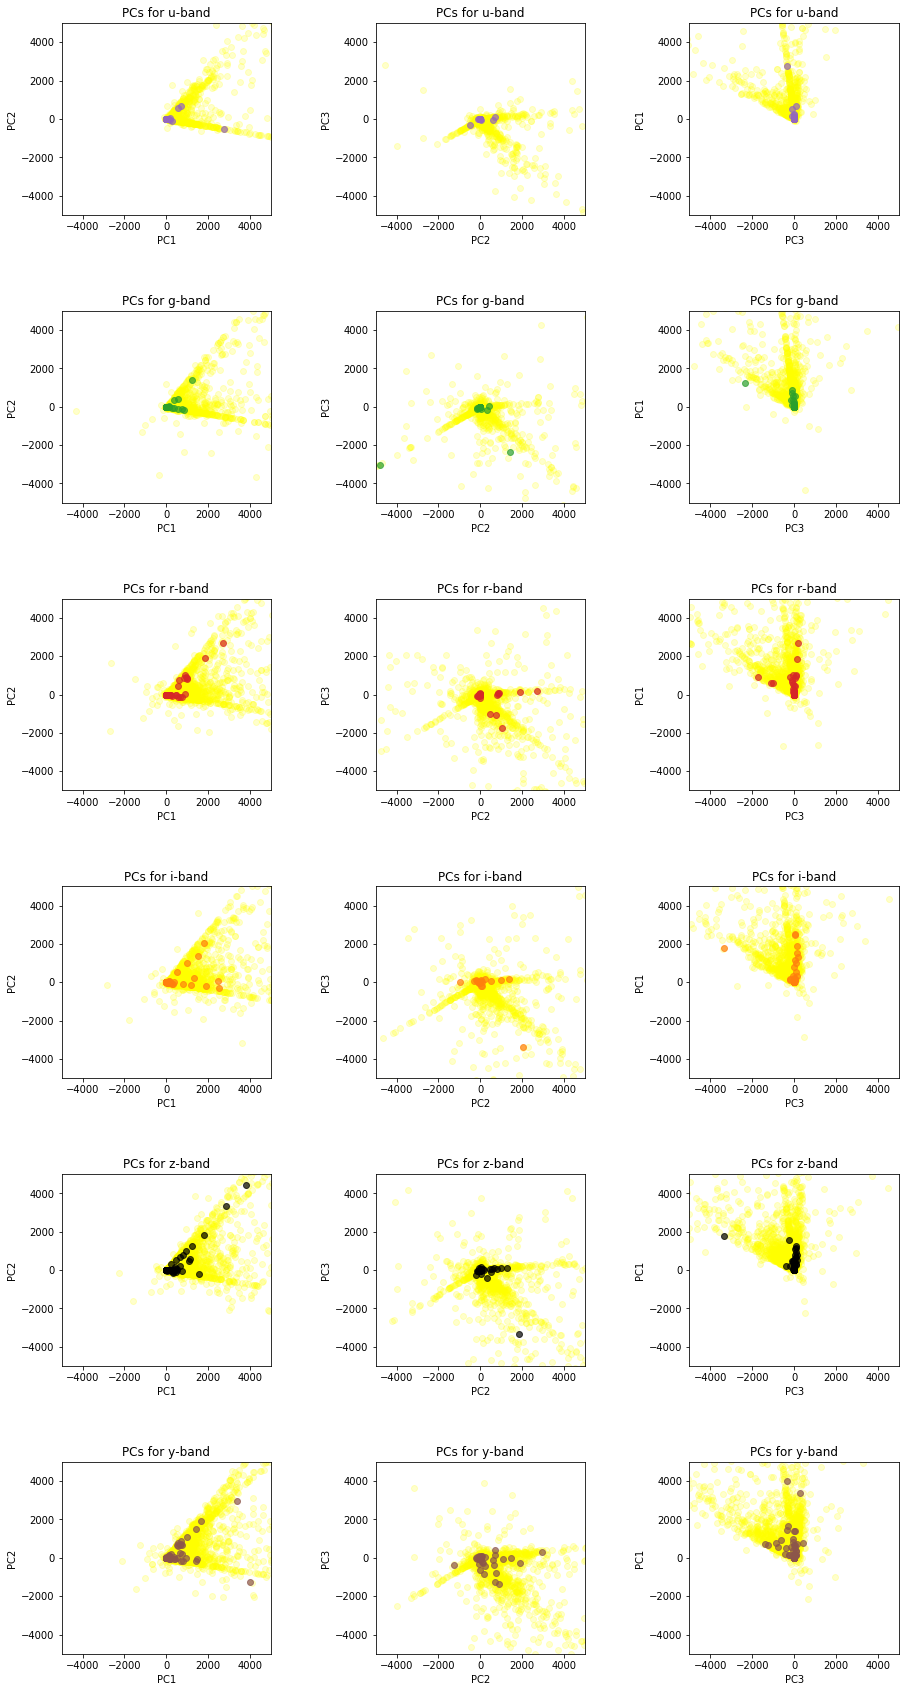

In [142]:
plt_PLAsTiCC_coeff(object_ids = object_ids, coeff_dict_list=coeff_dict_list, color_band_dict=color_band_dict)

In [ ]:
print(len(index))

In [ ]:
index = get_kilonova_loc(object_list)